In [235]:
from utils import *
from data_utils import *
from metrics import *
from plots import *

from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from numpy import where
from matplotlib import pyplot
from types import SimpleNamespace
from tqdm import tqdm


In [254]:
# ---------------------------------------- DATA GENERATION ------------------------------------
# generate samples for blobs problem with a given random seed
def samples_for_seed(seed, num_classes=3):
    # generate samples
    X, y = make_blobs(n_samples=1000, centers=num_classes, n_features=2, cluster_std=2, random_state=seed)
    return X, y

def prep_samples(X, y, n_train = 500):
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]

    # Create DataLoaders
    train_dataset = TensorDataset(torch.FloatTensor(trainX), torch.LongTensor(trainy))
    test_dataset = TensorDataset(torch.FloatTensor(testX), torch.LongTensor(testy))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_loader, test_loader
 
# --------------------------------------------- PLOTS --------------------------------------------
# create a scatter plot of points colored by class value
def plot_samples(X, y, classes=3):
    # plot points for each class
    for i in range(classes):
        # select indices of points with each class label
        samples_ix = where(y == i)
        # plot points for this class with a given color
        pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1])

def plot_decision_boundary(model, X, y, n_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

def plot_layer_ranks(model):
    ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            rank = np.linalg.matrix_rank(weight_matrix)
            ranks.append(rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(layer_names, ranks, color='blue')
    plt.xlabel('Layer')
    plt.ylabel('Rank')
    plt.title('Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(y_min, y_max, step=2))  # Set yticks

    plt.show()

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model):
    effective_ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(35, 12))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# -------------------------------------- MODEL FUNCTIONS --------------------------------------------
# define and fit model on a training dataset
def fit_model(train_loader, test_loader, verbose=False):
    # define model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    params = dict(device=device,
        width=5, lr=0.005, num_train=100,
        sb=0.05, depth=3, sw=1.7346938775510203, early_stop_patience = None, activation_function='relu')
    # Create DNN model
    input_dim = 2  # 2D data points
    output_dim = 3  # Number of classes
    model = generate_fc_dnn(input_dim, output_dim, params, gaussian_init=False, activation_function=nn.ReLU)

    # train
    # Create a 'Namespace' to supply to the training function (to comply with your function's requirements)
    dataset_namespace = SimpleNamespace(train_loader=train_loader, test_loader=test_loader, val_loader=test_loader)
    train_acc, test_acc, model, _ = compute_training_acc_epochs(model, dataset_namespace, params, debug=verbose)

    if verbose:
        print(f"Final Training Accuracy: {train_acc:.4f}")
        print(f"Final Test Accuracy: {test_acc:.4f}")
    return model

def fine_tune_model(pretrained_model, train_loader, test_loader, verbose=False):
    model = copy.deepcopy(pretrained_model)
    # define model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    params = dict(device=device,
        width=5, lr=0.005, num_train=100,
        sb=0.05, depth=3, sw=1.7346938775510203, early_stop_patience = None, activation_function='relu')
    # train
    # Create a 'Namespace' to supply to the training function (to comply with your function's requirements)
    dataset_namespace = SimpleNamespace(train_loader=train_loader, test_loader=test_loader, val_loader=test_loader)
    train_acc, test_acc, model, _ = compute_training_acc_epochs(model, dataset_namespace, params, debug=verbose)

    if verbose:
        print(f"Final Training Accuracy: {train_acc:.4f}")
        print(f"Final Test Accuracy: {test_acc:.4f}")
    return model

def eval(model, device, dataset_loader, debug=False):
    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))
        print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(len(set(all_labels)))]))
    return acc

# --------------------------------------- EXPERIMENTS -----------------------------------------------------
# repeatedly train (or fine-tune) and evaluate the trained (or fine-tuned) model
# also if we are fine-tuning, freeze the first cut_point layers 
def eval_multiple_experiments(train_loader, test_loader, n_repeats, pretrained_model=None, cut_point=0, debug=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scores = list()
    for _ in tqdm(range(n_repeats)):
		# define and fit a new model on the train dataset
        if pretrained_model:
            model = fine_tune_model(pretrained_model, train_loader, test_loader)
            layers = list(model.children())
            for i in range(cut_point):
                for param in layers[2*i].parameters():
                    param.requires_grad = False
        else:
            model = fit_model(train_loader, test_loader)
		# evaluate model on test dataset
        test_acc = eval(model, device, test_loader, debug)
        scores.append(test_acc)
    return scores

# Generate Data for Problems 1 and 2: Pretrain on 1 and Fine-tune on 2

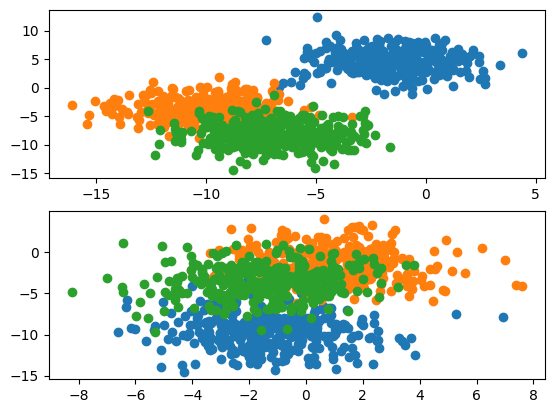

In [249]:
# generate multiple problems
n_problems = 2
for i in range(1, n_problems+1):
    # specify subplot
    pyplot.subplot(210 + i)
    # generate samples
    X, y = samples_for_seed(i)
    # scatter plot of samples
    plot_samples(X, y)
# plot figure
pyplot.show()

# Pretrain a Model on Problem 1

In [250]:
X, y = samples_for_seed(1)
train_loader, test_loader = prep_samples(X, y)

In [251]:
pretrained_model = fit_model(train_loader, test_loader, verbose=True)

Epoch: 0 	Training Accuracy: 35.40%
Validation Accuracy: 31.20%
Epoch: 1 	Training Accuracy: 35.40%
Validation Accuracy: 31.20%
Epoch: 2 	Training Accuracy: 35.40%
Validation Accuracy: 31.20%
Epoch: 3 	Training Accuracy: 35.40%
Validation Accuracy: 31.20%
Epoch: 4 	Training Accuracy: 35.40%
Validation Accuracy: 31.20%
Epoch: 5 	Training Accuracy: 36.40%
Validation Accuracy: 31.80%
Epoch: 6 	Training Accuracy: 47.60%
Validation Accuracy: 46.40%
Epoch: 7 	Training Accuracy: 58.40%
Validation Accuracy: 59.80%
Epoch: 8 	Training Accuracy: 71.60%
Validation Accuracy: 74.60%
Epoch: 9 	Training Accuracy: 75.80%
Validation Accuracy: 77.40%
Epoch: 10 	Training Accuracy: 78.80%
Validation Accuracy: 79.40%
Epoch: 11 	Training Accuracy: 82.20%
Validation Accuracy: 81.80%
Epoch: 12 	Training Accuracy: 85.40%
Validation Accuracy: 85.00%
Epoch: 13 	Training Accuracy: 85.80%
Validation Accuracy: 85.40%
Epoch: 14 	Training Accuracy: 85.80%
Validation Accuracy: 85.20%
Epoch: 15 	Training Accuracy: 88.60

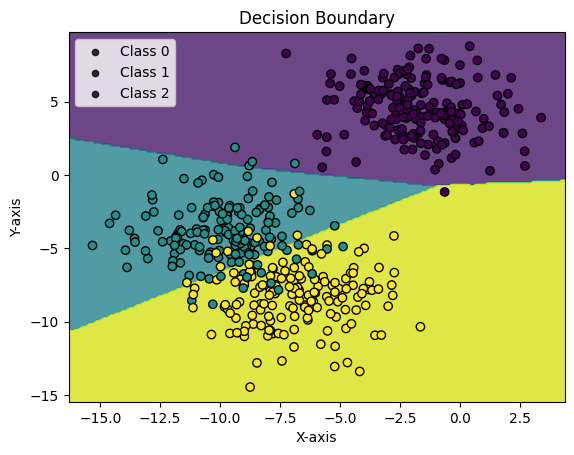

In [252]:
plot_decision_boundary(pretrained_model, test_loader.dataset.tensors[0], test_loader.dataset.tensors[1], n_classes=3)

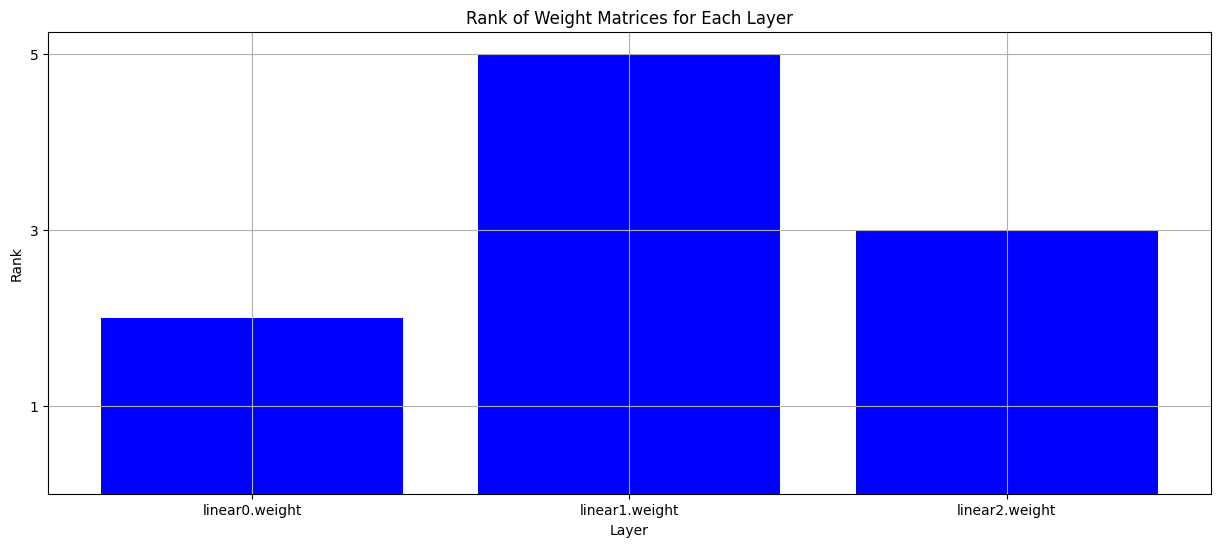

In [253]:
plot_layer_ranks(pretrained_model) 

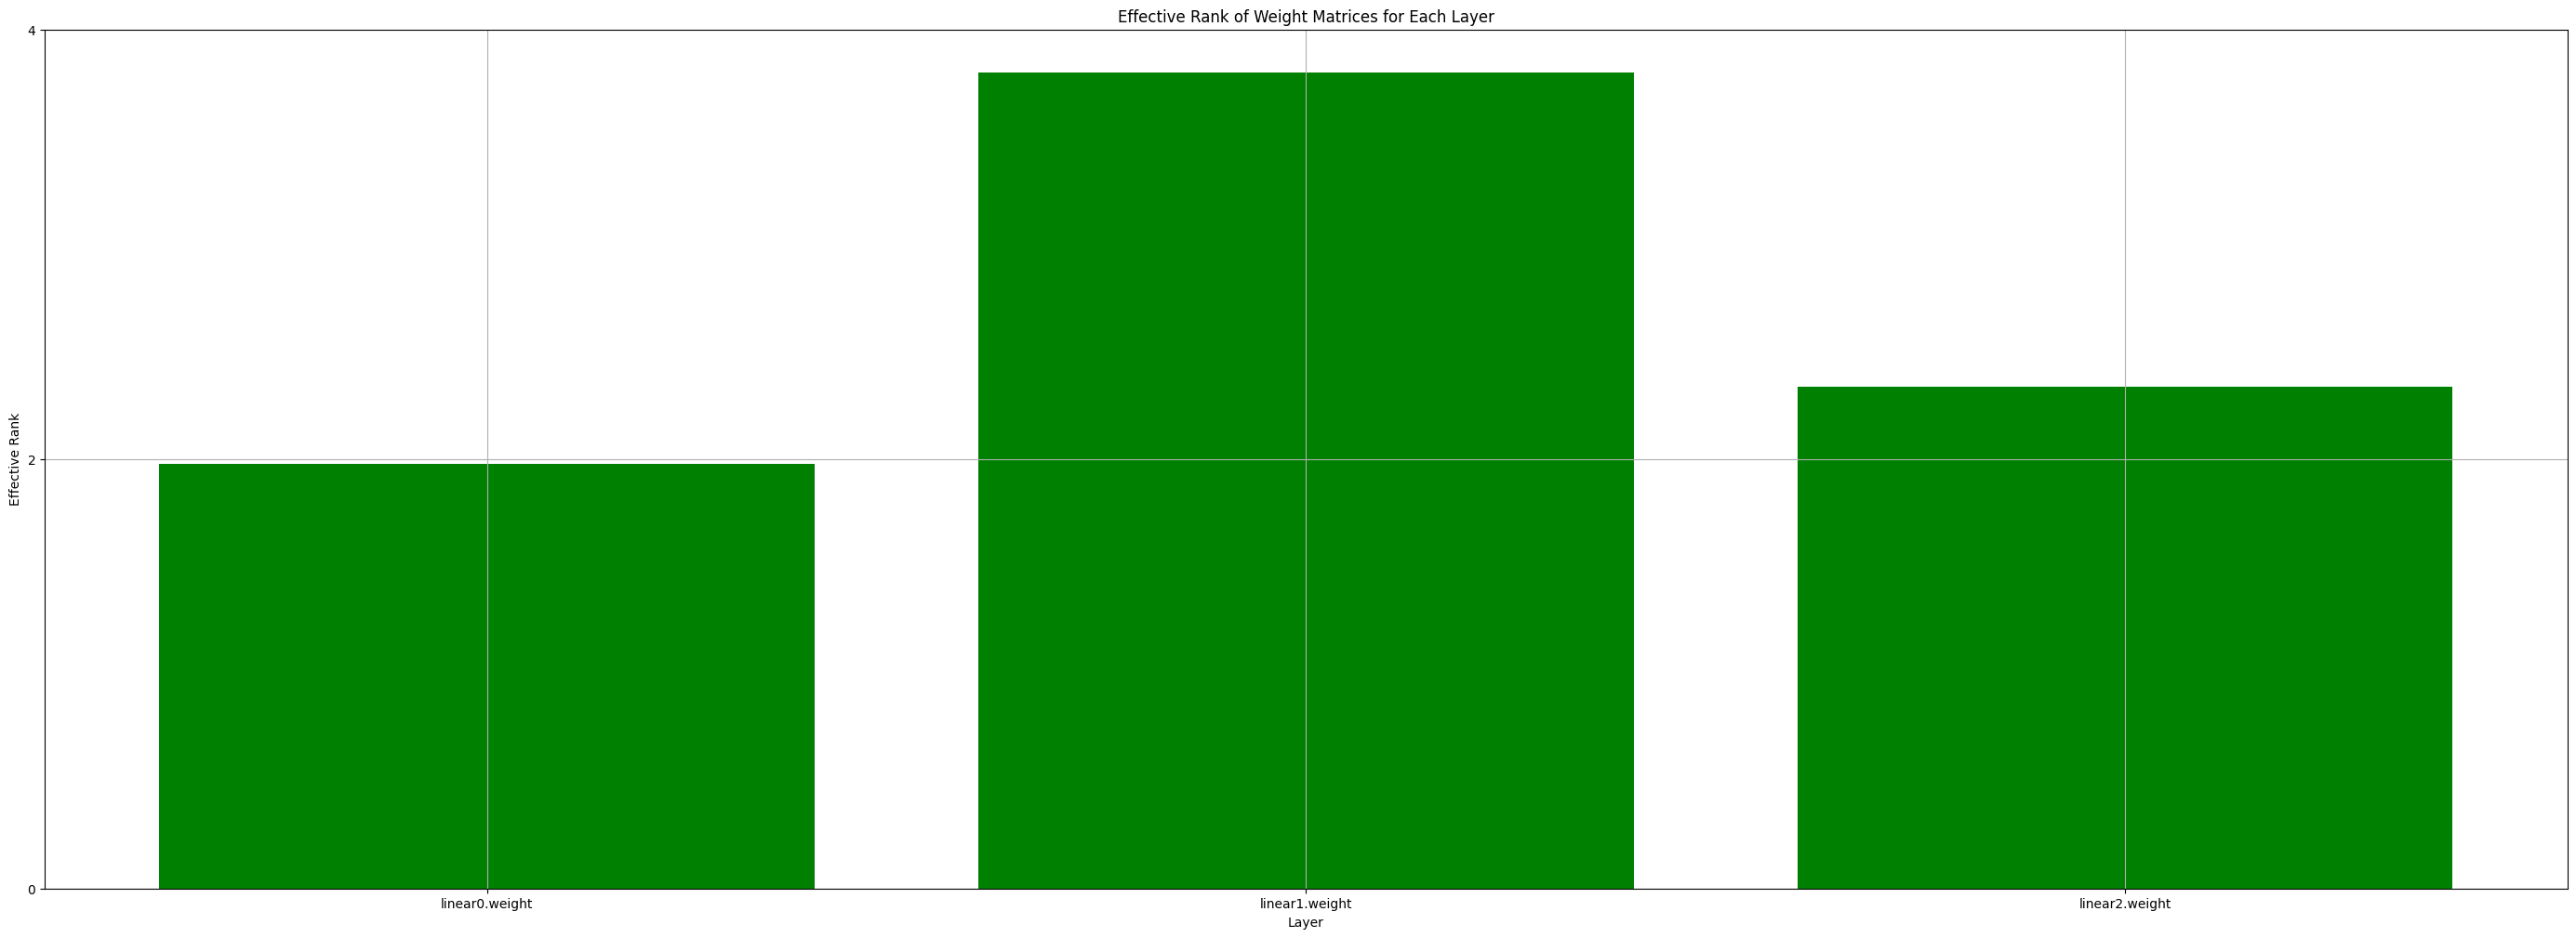

In [255]:
plot_layer_effective_ranks(pretrained_model)

c:\Users\user\Desktop\MP\mp-tl-study\plots.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
c:\Users\user\Desktop\MP\mp-tl-study\plots.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


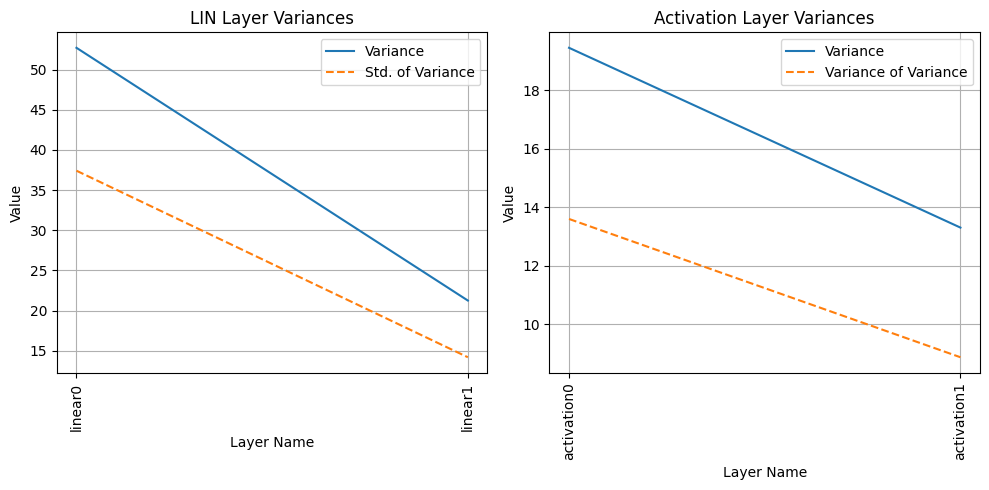

In [256]:
results, variances = compute_layer_variances_dense(pretrained_model, test_loader, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

# Train a Model only on Problem 2 data
What we aim is: The fine-tuned model (Problem 1 -> 2) should be better than the one trained only on 2

In [241]:
X, y = samples_for_seed(2)
train_loader, test_loader = prep_samples(X, y)
standalone_model = fit_model(train_loader, test_loader, verbose=True)

Epoch: 0 	Training Accuracy: 30.60%
Validation Accuracy: 28.80%
Epoch: 1 	Training Accuracy: 30.40%
Validation Accuracy: 28.80%
Epoch: 2 	Training Accuracy: 30.20%
Validation Accuracy: 29.00%
Epoch: 3 	Training Accuracy: 30.20%
Validation Accuracy: 29.00%
Epoch: 4 	Training Accuracy: 30.40%
Validation Accuracy: 29.00%
Epoch: 5 	Training Accuracy: 30.40%
Validation Accuracy: 29.00%
Epoch: 6 	Training Accuracy: 30.60%
Validation Accuracy: 29.40%
Epoch: 7 	Training Accuracy: 30.80%
Validation Accuracy: 29.40%
Epoch: 8 	Training Accuracy: 31.00%
Validation Accuracy: 29.40%
Epoch: 9 	Training Accuracy: 31.00%
Validation Accuracy: 29.60%
Epoch: 10 	Training Accuracy: 31.00%
Validation Accuracy: 30.00%
Epoch: 11 	Training Accuracy: 31.00%
Validation Accuracy: 30.20%
Epoch: 12 	Training Accuracy: 31.40%
Validation Accuracy: 31.00%
Epoch: 13 	Training Accuracy: 31.40%
Validation Accuracy: 31.20%
Epoch: 14 	Training Accuracy: 31.60%
Validation Accuracy: 31.40%
Epoch: 15 	Training Accuracy: 32.00

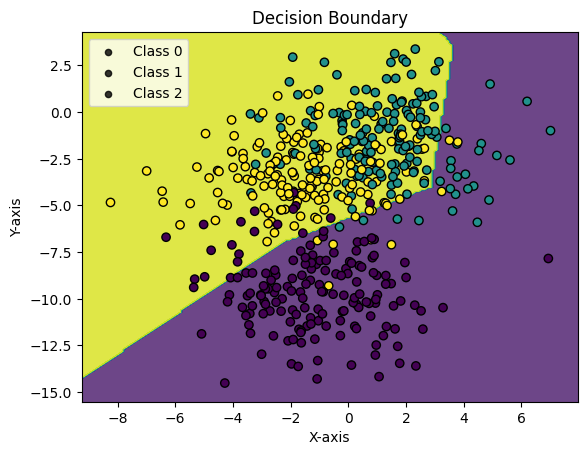

In [242]:
plot_decision_boundary(standalone_model, test_loader.dataset.tensors[0], test_loader.dataset.tensors[1], n_classes=3)

# Now Fine-tune on Problem 2

In [243]:
fine_tuned_model = fine_tune_model(pretrained_model, train_loader, test_loader, verbose=True)

Epoch: 0 	Training Accuracy: 25.60%
Validation Accuracy: 29.60%
Epoch: 1 	Training Accuracy: 32.20%
Validation Accuracy: 34.20%
Epoch: 2 	Training Accuracy: 35.20%
Validation Accuracy: 35.40%
Epoch: 3 	Training Accuracy: 36.20%
Validation Accuracy: 36.80%
Epoch: 4 	Training Accuracy: 37.80%
Validation Accuracy: 39.60%
Epoch: 5 	Training Accuracy: 38.80%
Validation Accuracy: 40.60%
Epoch: 6 	Training Accuracy: 40.20%
Validation Accuracy: 40.40%
Epoch: 7 	Training Accuracy: 40.60%
Validation Accuracy: 39.80%
Epoch: 8 	Training Accuracy: 40.60%
Validation Accuracy: 40.60%
Epoch: 9 	Training Accuracy: 41.40%
Validation Accuracy: 41.20%
Epoch: 10 	Training Accuracy: 41.40%
Validation Accuracy: 41.20%
Epoch: 11 	Training Accuracy: 41.80%
Validation Accuracy: 41.80%
Epoch: 12 	Training Accuracy: 42.40%
Validation Accuracy: 42.20%
Epoch: 13 	Training Accuracy: 42.60%
Validation Accuracy: 42.00%
Epoch: 14 	Training Accuracy: 43.00%
Validation Accuracy: 42.20%
Epoch: 15 	Training Accuracy: 43.00

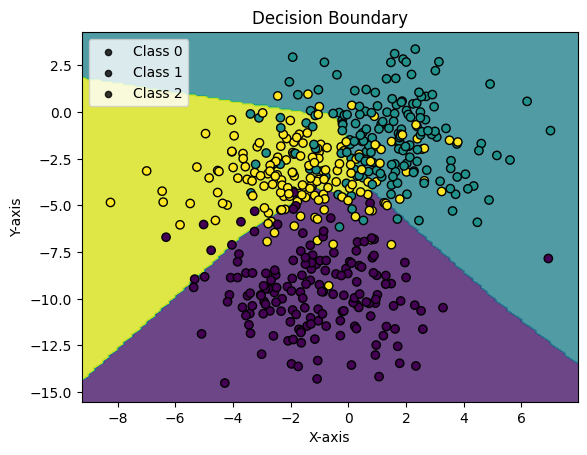

In [244]:
plot_decision_boundary(fine_tuned_model, test_loader.dataset.tensors[0], test_loader.dataset.tensors[1], n_classes=3)

# Now Multiple Experiments to Test our Hypothesis
What we aim is: The fine-tuned model (Problem 1 -> 2) should be better than the one trained only on 2

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:34<00:00,  3.13s/it]


Standalone 0.800 (0.025)


 33%|███▎      | 1/3 [01:56<03:52, 116.49s/it]

Transfer (fixed=0) 0.791 (0.002)


 67%|██████▋   | 2/3 [03:21<01:37, 97.69s/it] 

Transfer (fixed=1) 0.791 (0.002)


100%|██████████| 3/3 [04:43<00:00, 94.50s/it]


Transfer (fixed=2) 0.791 (0.002)


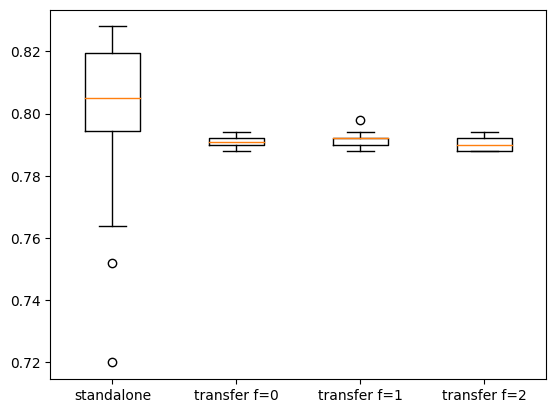

In [247]:
# prepare data for problem 2
X, y = samples_for_seed(2)
train_loader, test_loader = prep_samples(X, y)
n_repeats = 30
dists, dist_labels = list(), list()

# repeated evaluation of standalone model
standalone_scores = eval_multiple_experiments(train_loader, test_loader, n_repeats)
print('Standalone %.3f (%.3f)' % (np.mean(standalone_scores), np.std(standalone_scores)))
dists.append(standalone_scores)
dist_labels.append('standalone')

# repeated evaluation of transfer learning model, vary fixed layers
n_fixed = 3
for i in range(n_fixed):
	scores = eval_multiple_experiments(train_loader, test_loader, n_repeats, pretrained_model=pretrained_model, cut_point=i)
	print('Transfer (fixed=%d) %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))
	dists.append(scores)
	dist_labels.append('transfer f='+str(i))

# box and whisker plot of score distributions
pyplot.boxplot(dists, labels=dist_labels)
pyplot.show()

# Result
Transfer learning doesn't improve the accuracy much, but it makes the training more robust in a way. f = cut point. We can play with other params too (for example here there is no early stopping)